  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...
label
ham     4825
spam     747
Name: count, dtype: int64
Best Parameters: {'C': 1}
Best CV Accuracy: 0.9838
Accuracy: 0.983

Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       966
           1       0.96      0.91      0.93       149

    accuracy                           0.98      1115
   macro avg       0.97      0.95      0.96      1115
weighted avg       0.98      0.98      0.98      1115



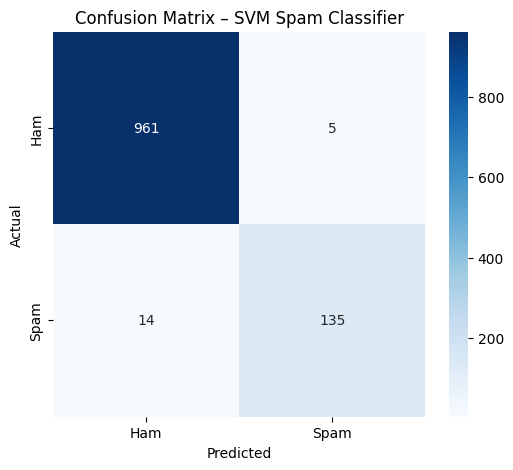

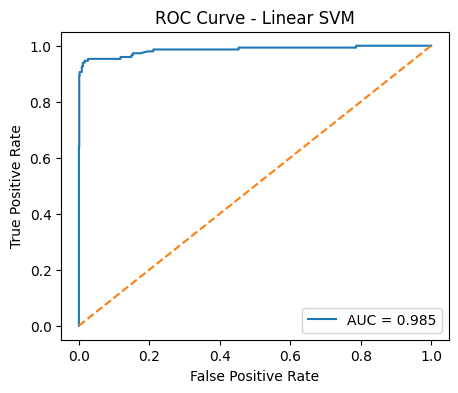

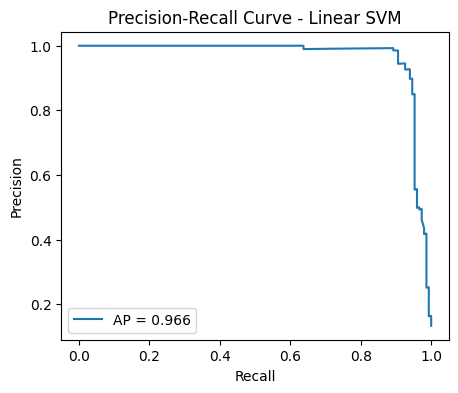

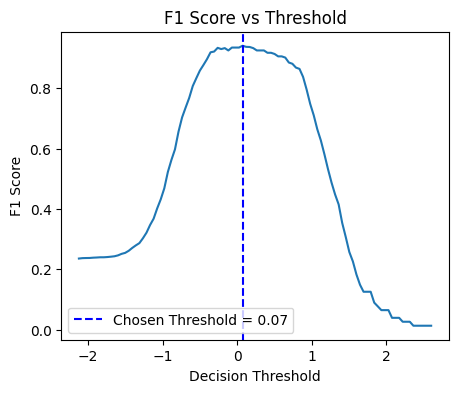

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
df = pd.read_csv("spam.csv", encoding="latin1")
df = df[['v1', 'v2']]   # keep only required columns
df.columns = ['label', 'message']

print(df.head())
print(df['label'].value_counts())
df['label'] = df['label'].map({'ham': 0, 'spam': 1})
X_train, X_test, y_train, y_test = train_test_split(
    df['message'],
    df['label'],
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)
tfidf = TfidfVectorizer(
    stop_words='english',
    max_df=0.95,
    min_df=2
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# -------------------------
# Hyperparameter Tuning
# -------------------------
param_grid = {
    'C': [0.01, 0.1, 1, 10]
}

svm = LinearSVC(
    class_weight='balanced',
    random_state=42,
    max_iter=5000
)

grid = GridSearchCV(
    svm,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid.fit(X_train_tfidf, y_train)

# Best model
svm_model = grid.best_estimator_

print("Best Parameters:", grid.best_params_)
print("Best CV Accuracy:", round(grid.best_score_, 4))

y_pred = svm_model.predict(X_test_tfidf)

from sklearn.metrics import (
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
    f1_score
)

# =========================
# Decision scores
# =========================
y_scores = svm_model.decision_function(X_test_tfidf)

print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Ham', 'Spam'],
    yticklabels=['Ham', 'Spam']
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – SVM Spam Classifier")
plt.show()


fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Linear SVM")
plt.legend()
plt.show()

precision, recall, _ = precision_recall_curve(y_test, y_scores)
ap_score = average_precision_score(y_test, y_scores)

plt.figure(figsize=(5,4))
plt.plot(recall, precision, label=f"AP = {ap_score:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Linear SVM")
plt.legend()
plt.show()

thresholds = np.linspace(min(y_scores), max(y_scores), 100)
f1_scores = []

for t in thresholds:
    y_pred_thresh = (y_scores >= t).astype(int)
    f1_scores.append(f1_score(y_test, y_pred_thresh))

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

plt.figure(figsize=(5,4))
plt.plot(thresholds, f1_scores)
plt.axvline(
    best_threshold,
    linestyle='--',
    color='blue',
    label=f"Chosen Threshold = {best_threshold:.2f}"
)
plt.xlabel("Decision Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Threshold")
plt.legend()
plt.show()
